In [6]:
import pandas as pd

# Load the training and test datasets
train_df = pd.read_csv("../data/Q1/train.csv")
test_df = pd.read_csv("../data/Q1/test.csv")

In [7]:
import numpy as np

class NaiveBayes:
    def __init__(self):
        self.class_priors = {}  # Stores log P(C)
        self.word_counts = {}  # Stores word frequencies per class
        self.class_word_totals = {}  # Total words per class
        self.vocab = set()  # Vocabulary set
        self.smoothening = 1.0
        
    def fit(self, df, smoothening, class_col="Class Index", text_col="Tokenized Description"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed.

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                Each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        self.smoothening = smoothening
        class_counts = df[class_col].value_counts().to_dict()
        total_docs = len(df)
        
        # Compute prior probabilities P(C)
        self.class_priors = {c: np.log(count / total_docs) for c, count in class_counts.items()}
        
        # Initialize structures for word counts
        self.word_counts = {cls: {} for cls in class_counts}
        self.class_word_totals = {cls: 0 for cls in class_counts}
        
        # Compute word counts per class
        for _, row in df.iterrows():
            cls = row[class_col]
            tokens = row[text_col]
            self.class_word_totals[cls] += len(tokens)
            
            for token in tokens:
                if token not in self.word_counts[cls]:
                    self.word_counts[cls][token] = 0
                self.word_counts[cls][token] += 1
                self.vocab.add(token)
    
    def predict(self, df, text_col="Tokenized Description", predicted_col="Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                Each entry of text_col is a list of tokens.
        """
        predictions = []
        V = len(self.vocab)  # Vocabulary size
        
        for _, row in df.iterrows():
            tokens = row[text_col]
            class_scores = {}
            
            # Compute log-probabilities for each class
            for cls in self.class_priors:
                log_prob = self.class_priors[cls]
                total_words_in_class = self.class_word_totals[cls]
                
                for token in tokens:
                    word_freq = self.word_counts[cls].get(token, 0)
                    log_prob += np.log((word_freq + self.smoothening) / 
                                       (total_words_in_class + self.smoothening * V))
                    
                class_scores[cls] = log_prob
            
            # Assign class with maximum probability
            predictions.append(max(class_scores, key=class_scores.get))
        
        df[predicted_col] = predictions


In [8]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams

nltk.download("punkt")
nltk.download("stopwords")

def tokenize_text(text, flag=0):
    """
    Tokenizes input text based on the flag parameter.

    Args:
        text (str): The input text to be tokenized.
        flag (int): Determines the level of tokenization:
            0 - Simple tokenization (lowercasing and splitting by whitespace).
            1 - Tokenization with stopword removal, punctuation removal, and stemming.
            2 - Tokenization with stopword removal, stemming, and bigram feature engineering.

    Returns:
        List[str]: A list of tokenized words or bigrams.
    """
    text = text.lower()

    if flag == 0:
        # Simple tokenization (lowercase + split by space)
        return text.split()

    # Tokenize words using NLTK
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    if flag == 1:
        return tokens  # Return unigrams with stemming

    elif flag == 2:
        # Generate bigrams
        bigram_tokens = list(ngrams(tokens, 2))
        bigram_tokens = [" ".join(bigram) for bigram in bigram_tokens]

        # Return both unigrams and bigrams
        return tokens + bigram_tokens

    return tokens  # Default case (shouldn't be reached)


[nltk_data] Downloading package punkt to /home/anup/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anup/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordclouds(df, class_col="Class Index", text_col="Tokenized Description", class_labels=None):
    """
    Generate and display word clouds for each class.

    Args:
        df (pd.DataFrame): Dataframe containing the tokenized text.
        class_col (str): Column representing class labels.
        text_col (str): Column containing tokenized text.
        class_labels (dict): Mapping from class indices to class names.
    """
    if class_labels is None:
        class_labels = {1: "World", 2: "Sports", 3: "Business", 4: "Science/Tech"}

    plt.figure(figsize=(6, 5))
    
    for idx, (class_id, class_name) in enumerate(class_labels.items(), 1):
        text_data = df[df[class_col] == class_id][text_col].explode()  # Flatten token lists
        word_freq = text_data.value_counts().to_dict()  # Count word occurrences
        
        wordcloud = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(word_freq)
        
        plt.subplot(2, 2, idx)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(class_name)
    
    plt.tight_layout()
    plt.show()



In [13]:
nltk.download('punkt_tab')
train_df["Tokenized Description 1"] = train_df["Description"].apply(lambda x: tokenize_text(x, 0))
train_df["Tokenized Description 2"] = train_df["Description"].apply(lambda x: tokenize_text(x, 1))
test_df["Tokenized Description 1"] = test_df["Description"].apply(lambda x: tokenize_text(x, 0))
test_df["Tokenized Description 2"] = test_df["Description"].apply(lambda x: tokenize_text(x, 1))

[nltk_data] Downloading package punkt_tab to /home/anup/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


WordCloud for Unigram Tokenization on train data


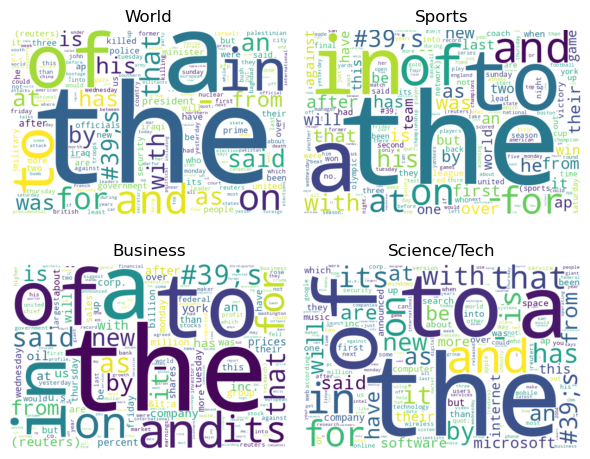

WordCloud for Unigram Tokenization on test data


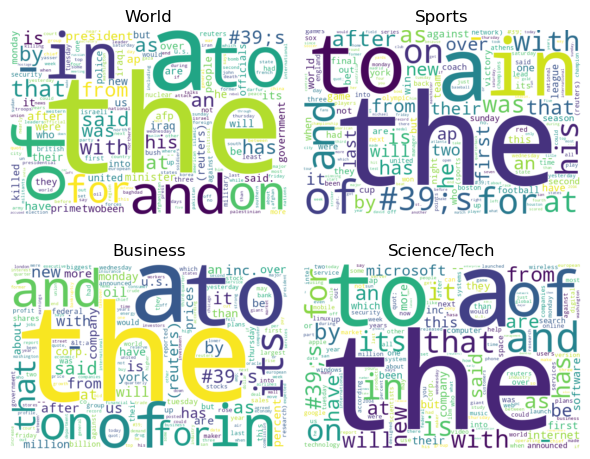

WordCloud for Unigram Tokenization + Stopword Removal + Stemming on train data


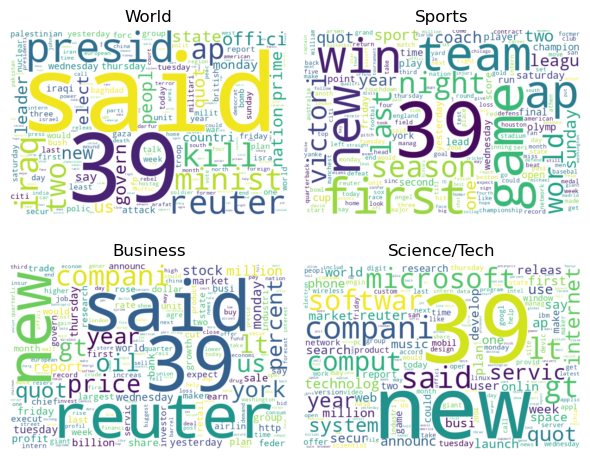

WordCloud for Unigram Tokenization + Stopword Removal + Stemming on test data


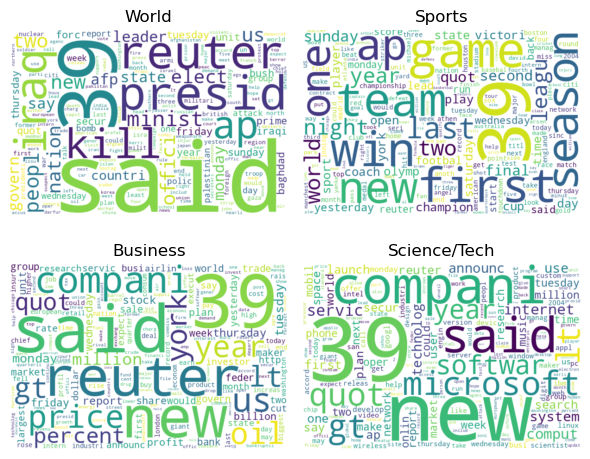

In [14]:
print("WordCloud for Unigram Tokenization on train data")
generate_wordclouds(train_df, text_col="Tokenized Description 1")

print("WordCloud for Unigram Tokenization on test data")
generate_wordclouds(test_df, text_col="Tokenized Description 1")

print("WordCloud for Unigram Tokenization + Stopword Removal + Stemming on train data")
generate_wordclouds(train_df, text_col="Tokenized Description 2")

print("WordCloud for Unigram Tokenization + Stopword Removal + Stemming on test data")
generate_wordclouds(test_df, text_col="Tokenized Description 2")


In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(train_df, test_df, flag, smoothening=1.0):
    """
    Trains the NaiveBayes model with a given flag setting and evaluates its performance on both train and test data.

    Args:
        train_df (pd.DataFrame): Training dataset with tokenized text.
        test_df (pd.DataFrame): Test dataset with tokenized text.
        flag (int): Tokenization flag (0: simple, 1: stopword removal, 2: bigrams).
        smoothening (float): Laplace smoothing parameter.

    Returns:
        dict: Dictionary containing train and test accuracy, precision, recall, F1-score.
    """

    # Tokenize training and test data
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df["Tokenized Description"] = train_df["Description"].apply(lambda x: tokenize_text(x, flag))
    test_df["Tokenized Description"] = test_df["Description"].apply(lambda x: tokenize_text(x, flag))

    # Train Naïve Bayes model
    nb = NaiveBayes()
    nb.fit(train_df, smoothening, text_col="Tokenized Description")

    # Make predictions on train and test data
    nb.predict(train_df, text_col="Tokenized Description")
    nb.predict(test_df, text_col="Tokenized Description")

    # Get true labels and predictions
    y_train_true, y_train_pred = train_df["Class Index"], train_df["Predicted"]
    y_test_true, y_test_pred = test_df["Class Index"], test_df["Predicted"]

    # Compute train metrics
    train_metrics = precision_recall_fscore_support(y_train_true, y_train_pred, average="weighted")
    train_support = len(y_train_true)

    # Compute test metrics
    test_metrics = precision_recall_fscore_support(y_test_true, y_test_pred, average="weighted")
    test_support = len(y_test_true)

    return {
        "Train Accuracy": accuracy_score(y_train_true, y_train_pred),
        "Train Precision": train_metrics[0],
        "Train Recall": train_metrics[1],
        "Train F1-score": train_metrics[2],
        "Train Support": train_support,
        "Test Accuracy": accuracy_score(y_test_true, y_test_pred),
        "Test Precision": test_metrics[0],
        "Test Recall": test_metrics[1],
        "Test F1-score": test_metrics[2],
        "Test Support": test_support
    }


In [21]:
# Evaluate models with different feature engineering settings
results = {
    "Unigram ": evaluate_model(train_df, test_df, flag=0),
    "Unigram + Stopword Removal + Stemming ": evaluate_model(train_df, test_df, flag=1),
    "Unigram + Bigrams on top of above ": evaluate_model(train_df, test_df, flag=2),
}


In [37]:
# Display results
import pandas as pd
results_df = pd.DataFrame(results)
def print_results(results):
    """
    Prints the evaluation results in a well-structured format with each flag's results in a separate paragraph.

    Args:
        results (dict): Dictionary containing train and test metrics for different flag settings.
    """
    for flag, metrics in results.items():
        print(f"### Results for Tokenization Flag = {flag} ###\n")
        print(f"Train Accuracy:    {metrics['Train Accuracy']:.6f}")
        print(f"Train Precision:   {metrics['Train Precision']:.6f}")
        print(f"Train Recall:      {metrics['Train Recall']:.6f}")
        print(f"Train F1-score:    {metrics['Train F1-score']:.6f}")
        print(f"Train Support:     {metrics['Train Support']}\n")

        print(f"Test Accuracy:     {metrics['Test Accuracy']:.6f}")
        print(f"Test Precision:    {metrics['Test Precision']:.6f}")
        print(f"Test Recall:       {metrics['Test Recall']:.6f}")
        print(f"Test F1-score:     {metrics['Test F1-score']:.6f}")
        print(f"Test Support:      {metrics['Test Support']}\n")
        
        print("-" * 50, "\n")  # Separator for readability

print_results(results_df)
# print(results_df["Train Accuracy"])
# print(results_df["Test Accuracy"])
# print(results_df["Train Precision"])
# print(results_df["Test Precision"])
# print(results_df["Train Recall"])
# print(results_df["Test Recall"])
# print(results_df["Train F1-score"])
# print(results_df["Test F1-score"])


### Results for Tokenization Flag = Unigram (flag=0) ###

Train Accuracy:    0.918067
Train Precision:   0.917840
Train Recall:      0.918067
Train F1-score:    0.917877
Train Support:     120000.0

Test Accuracy:     0.889342
Test Precision:    0.888944
Test Recall:       0.889342
Test F1-score:     0.889028
Test Support:      7600.0

-------------------------------------------------- 

### Results for Tokenization Flag = Unigram + Stopword Removal + Stemming  ###

Train Accuracy:    0.904217
Train Precision:   0.903955
Train Recall:      0.904217
Train F1-score:    0.904002
Train Support:     120000.0

Test Accuracy:     0.889868
Test Precision:    0.889583
Test Recall:       0.889868
Test F1-score:     0.889640
Test Support:      7600.0

-------------------------------------------------- 

### Results for Tokenization Flag = Unigram + Bigrams on top of above ###

Train Accuracy:    0.953000
Train Precision:   0.953127
Train Recall:      0.953000
Train F1-score:    0.952925
Train Sup

In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model_title(train_df, test_df, flag, smoothening=1.0):
    """
    Trains the NaiveBayes model with a given flag setting and evaluates its performance on both train and test data.

    Args:
        train_df (pd.DataFrame): Training dataset with tokenized text.
        test_df (pd.DataFrame): Test dataset with tokenized text.
        flag (int): Tokenization flag (0: simple, 1: stopword removal, 2: bigrams).
        smoothening (float): Laplace smoothing parameter.

    Returns:
        dict: Dictionary containing train and test accuracy, precision, recall, F1-score.
    """

    # Tokenize training and test data
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df["Tokenized Title"] = train_df["Title"].apply(lambda x: tokenize_text(x, flag))
    test_df["Tokenized Title"] = test_df["Title"].apply(lambda x: tokenize_text(x, flag))

    # Train Naïve Bayes model
    nb = NaiveBayes()
    nb.fit(train_df, smoothening, text_col="Tokenized Title")

    # Make predictions on train and test data
    nb.predict(train_df, text_col="Tokenized Title")
    nb.predict(test_df, text_col="Tokenized Title")

    # Get true labels and predictions
    y_train_true, y_train_pred = train_df["Class Index"], train_df["Predicted"]
    y_test_true, y_test_pred = test_df["Class Index"], test_df["Predicted"]

    # Compute train metrics
    train_metrics = precision_recall_fscore_support(y_train_true, y_train_pred, average="weighted")
    train_support = len(y_train_true)

    # Compute test metrics
    test_metrics = precision_recall_fscore_support(y_test_true, y_test_pred, average="weighted")
    test_support = len(y_test_true)

    return {
        "Train Accuracy": accuracy_score(y_train_true, y_train_pred),
        "Train Precision": train_metrics[0],
        "Train Recall": train_metrics[1],
        "Train F1-score": train_metrics[2],
        "Train Support": train_support,
        "Test Accuracy": accuracy_score(y_test_true, y_test_pred),
        "Test Precision": test_metrics[0],
        "Test Recall": test_metrics[1],
        "Test F1-score": test_metrics[2],
        "Test Support": test_support
    }


In [36]:
# Evaluate models with different feature engineering settings
results_title = {
    "Unigram ": evaluate_model_title(train_df, test_df, flag=0),
    "Unigram + Stopword Removal + Stemming ": evaluate_model_title(train_df, test_df, flag=1),
    "Unigram + Bigrams on top of above ": evaluate_model_title(train_df, test_df, flag=2),
}

In [38]:
results_title_df = pd.DataFrame(results_title)
def print_results(results):
    """
    Prints the evaluation results in a well-structured format with each flag's results in a separate paragraph.

    Args:
        results (dict): Dictionary containing train and test metrics for different flag settings.
    """
    for flag, metrics in results.items():
        print(f"### Results for Tokenization Flag = {flag} ###\n")
        print(f"Train Accuracy:    {metrics['Train Accuracy']:.6f}")
        print(f"Train Precision:   {metrics['Train Precision']:.6f}")
        print(f"Train Recall:      {metrics['Train Recall']:.6f}")
        print(f"Train F1-score:    {metrics['Train F1-score']:.6f}")
        print(f"Train Support:     {metrics['Train Support']}\n")

        print(f"Test Accuracy:     {metrics['Test Accuracy']:.6f}")
        print(f"Test Precision:    {metrics['Test Precision']:.6f}")
        print(f"Test Recall:       {metrics['Test Recall']:.6f}")
        print(f"Test F1-score:     {metrics['Test F1-score']:.6f}")
        print(f"Test Support:      {metrics['Test Support']}\n")
        
        print("-" * 50, "\n")  # Separator for readability

print_results(results_title_df)

### Results for Tokenization Flag = Unigram  ###

Train Accuracy:    0.898267
Train Precision:   0.898029
Train Recall:      0.898267
Train F1-score:    0.898055
Train Support:     120000.0

Test Accuracy:     0.862368
Test Precision:    0.861815
Test Recall:       0.862368
Test F1-score:     0.861940
Test Support:      7600.0

-------------------------------------------------- 

### Results for Tokenization Flag = Unigram + Stopword Removal + Stemming  ###

Train Accuracy:    0.876900
Train Precision:   0.876631
Train Recall:      0.876900
Train F1-score:    0.876730
Train Support:     120000.0

Test Accuracy:     0.855000
Test Precision:    0.854467
Test Recall:       0.855000
Test F1-score:     0.854625
Test Support:      7600.0

-------------------------------------------------- 

### Results for Tokenization Flag = Unigram + Bigrams on top of above  ###

Train Accuracy:    0.938300
Train Precision:   0.938348
Train Recall:      0.938300
Train F1-score:    0.938259
Train Support:  

WordCloud for Unigram Tokenization on train data


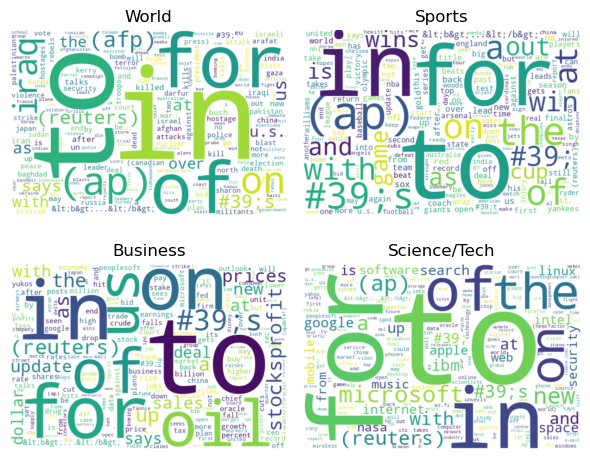

WordCloud for Unigram Tokenization on test data


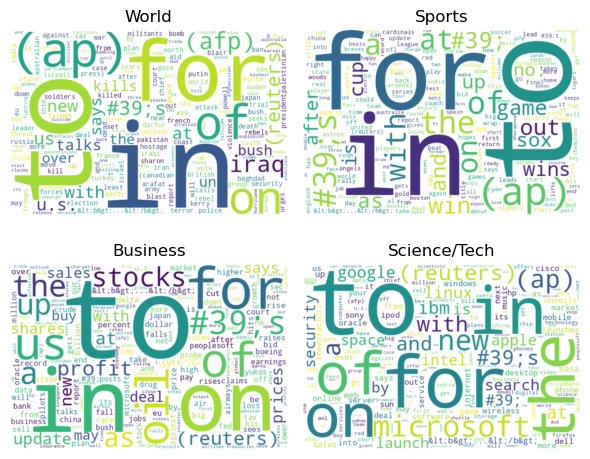

WordCloud for Unigram Tokenization + Stopword Removal + Stemming on train data


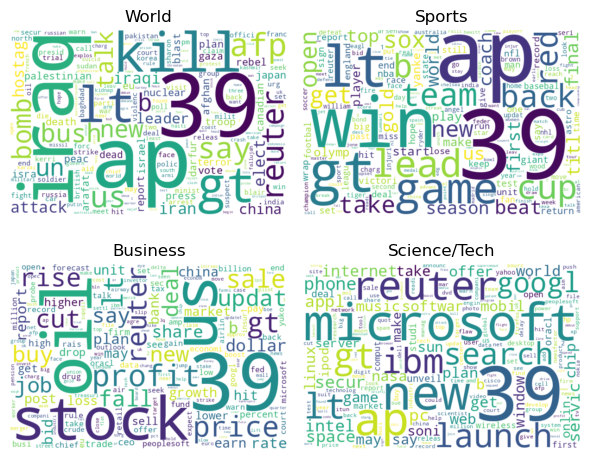

WordCloud for Unigram Tokenization + Stopword Removal + Stemming on test data


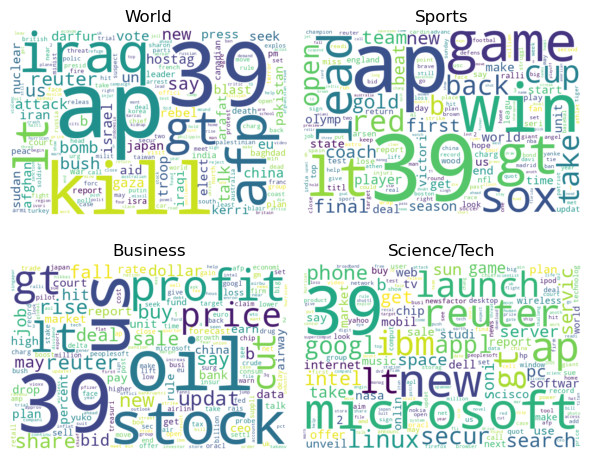

In [15]:
train_df["Tokenized Title 1"] = train_df["Title"].apply(lambda x: tokenize_text(x, 0))
train_df["Tokenized Title 2"] = train_df["Title"].apply(lambda x: tokenize_text(x, 1))

test_df["Tokenized Title 1"] = test_df["Title"].apply(lambda x: tokenize_text(x, 0))
test_df["Tokenized Title 2"] = test_df["Title"].apply(lambda x: tokenize_text(x, 1))


print("WordCloud for Unigram Tokenization on train data")
generate_wordclouds(train_df, text_col="Tokenized Title 1")

print("WordCloud for Unigram Tokenization on test data")
generate_wordclouds(test_df, text_col="Tokenized Title 1")

print("WordCloud for Unigram Tokenization + Stopword Removal + Stemming on train data")
generate_wordclouds(train_df, text_col="Tokenized Title 2")

print("WordCloud for Unigram Tokenization + Stopword Removal + Stemming on test data")
generate_wordclouds(test_df, text_col="Tokenized Title 2")

In [31]:
def merge_title_description(df):
    """
    Merge the title and description into a single text column.
    """
    df["Merged Text"] = df["Title"] + " " + df["Description"]
    return df

def evaluate_merged_model(train_df, test_df, flag, smoothening=1.0):
    """
    Train and evaluate Naïve Bayes model using merged title + description text.

    Args:
        train_df (pd.DataFrame): Training dataset with 'Title' and 'Description' columns.
        test_df (pd.DataFrame): Test dataset with 'Title' and 'Description' columns.
        flag (int): Tokenization flag (0: simple, 1: stopword removal, 2: bigrams).
        smoothening (float): Laplace smoothing parameter.

    Returns:
        dict: Accuracy, Precision, Recall, and F1-score.
    """
    # Merge title and description into one field
    train_df = merge_title_description(train_df)
    test_df = merge_title_description(test_df)

    # Tokenize merged text
    train_df["Tokenized Description"] = train_df["Merged Text"].apply(lambda x: tokenize_text(x, flag))
    test_df["Tokenized Description"] = test_df["Merged Text"].apply(lambda x: tokenize_text(x, flag))

    # Train and Predict
    nb = NaiveBayes()
    nb.fit(train_df, smoothening)
    nb.predict(test_df)

    # Compute Metrics
    y_true = test_df["Class Index"]
    y_pred = test_df["Predicted"]
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# Evaluate the model
merged_results = evaluate_merged_model(train_df, test_df, flag=2)
print("Merged Model Performance:", merged_results)


Merged Model Performance: {'Accuracy': 0.9118421052631579, 'Precision': 0.9116791736157314, 'Recall': 0.9118421052631579, 'F1-score': 0.9116596228408502}


In [27]:
class NaiveBayesSeparate:
    def __init__(self):
        self.class_probs = {}
        self.title_word_probs = {}
        self.desc_word_probs = {}
        self.vocab_title = set()
        self.vocab_desc = set()

    def fit(self, df, smoothening, class_col="Class Index", title_col="Title", desc_col="Description"):
        """
        Train the Naïve Bayes model separately for title and description.

        Args:
            df (pd.DataFrame): Training data.
            smoothening (float): Laplace smoothing parameter.
        """
        # Class probabilities
        class_counts = df[class_col].value_counts().to_dict()
        total_docs = len(df)
        self.class_probs = {c: np.log(count / total_docs) for c, count in class_counts.items()}

        # Initialize word counts
        title_word_counts = {c: {} for c in class_counts}
        desc_word_counts = {c: {} for c in class_counts}
        title_total_counts = {c: 0 for c in class_counts}
        desc_total_counts = {c: 0 for c in class_counts}

        # Tokenize and count words
        for _, row in df.iterrows():
            c = row[class_col]
            title_tokens = tokenize_text(row[title_col], 2)
            desc_tokens = tokenize_text(row[desc_col], 2)

            self.vocab_title.update(title_tokens)
            self.vocab_desc.update(desc_tokens)

            for word in title_tokens:
                title_word_counts[c][word] = title_word_counts[c].get(word, 0) + 1
                title_total_counts[c] += 1

            for word in desc_tokens:
                desc_word_counts[c][word] = desc_word_counts[c].get(word, 0) + 1
                desc_total_counts[c] += 1

        # Compute log probabilities with Laplace smoothing
        for c in class_counts:
            vocab_size_title = len(self.vocab_title)
            vocab_size_desc = len(self.vocab_desc)

            self.title_word_probs[c] = {
                word: np.log((title_word_counts[c].get(word, 0) + smoothening) /
                             (title_total_counts[c] + smoothening * (vocab_size_title + 1)))
                for word in self.vocab_title
            }

            self.desc_word_probs[c] = {
                word: np.log((desc_word_counts[c].get(word, 0) + smoothening) /
                             (desc_total_counts[c] + smoothening * (vocab_size_desc + 1)))
                for word in self.vocab_desc
            }

    def predict(self, df, title_col="Title", desc_col="Description", predicted_col="Predicted"):
        """
        Predict class probabilities using separate title and description likelihoods.
        """
        predictions = []
        for _, row in df.iterrows():
            title_tokens = tokenize_text(row[title_col], 2)
            desc_tokens = tokenize_text(row[desc_col], 2)

            best_class = None
            best_log_prob = float("-inf")

            for c in self.class_probs:
                log_prob = self.class_probs[c]

                for word in title_tokens:
                    log_prob += self.title_word_probs[c].get(word, np.log(1e-10))

                for word in desc_tokens:
                    log_prob += self.desc_word_probs[c].get(word, np.log(1e-10))

                if log_prob > best_log_prob:
                    best_log_prob = log_prob
                    best_class = c

            predictions.append(best_class)

        df[predicted_col] = predictions

# Train and evaluate the separate parameter model
nb_sep = NaiveBayesSeparate()
nb_sep.fit(train_df, smoothening=1.0)
nb_sep.predict(test_df)

# Compute metrics
y_true = test_df["Class Index"]
y_pred = test_df["Predicted"]
accuracy_sep = accuracy_score(y_true, y_pred)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print("Separate Model Performance:") 
print(f"Accuracy: {accuracy_sep:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Separate Model Performance:
Accuracy: 0.910789
Precision: 0.910640
Recall: 0.910789
F1-score: 0.910622


In [30]:
import numpy as np

# Number of classes (AG News has 4 classes)
num_classes = len(train_df["Class Index"].unique())

# (a) Random Guessing Accuracy
random_guess_accuracy = 1 / num_classes

# (b) Majority Class Baseline
most_frequent_class = train_df["Class Index"].value_counts().idxmax()
majority_class_accuracy = (test_df["Class Index"] == most_frequent_class).mean()

# (c) Improvement Over Baselines
best_model_accuracy = 0.902237  # Using the hardcoded flag=2 model

random_improvement = best_model_accuracy - random_guess_accuracy
majority_improvement = best_model_accuracy - majority_class_accuracy

# Print results
print(f"Random Guessing Accuracy: {random_guess_accuracy:.4f}")
print(f"Majority Class Baseline Accuracy: {majority_class_accuracy:.4f}")
print(f"Best Model Accuracy (Flag=2): {best_model_accuracy:.4f}")
print(f"Improvement over Random Guessing: {random_improvement:.4f}")
print(f"Improvement over Majority Class Baseline: {majority_improvement:.4f}")


Random Guessing Accuracy: 0.2500
Majority Class Baseline Accuracy: 0.2500
Best Model Accuracy (Flag=2): 0.9022
Improvement over Random Guessing: 0.6522
Improvement over Majority Class Baseline: 0.6522


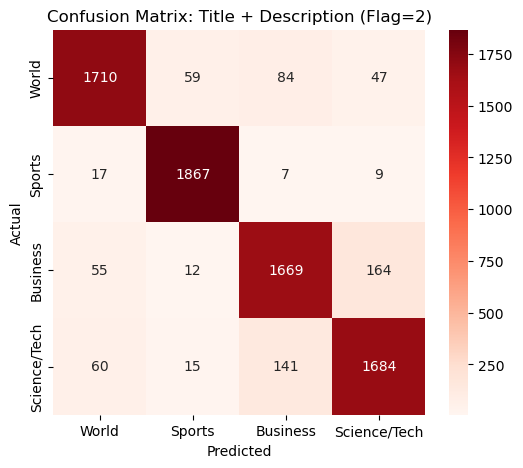

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_labels, title):
    """
    Plots a confusion matrix with actual class names instead of numerical indices.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_labels (dict): Dictionary mapping class indices to class names.
        title (str): Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    class_names = [class_labels[i] for i in sorted(class_labels)]  
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Example class labels dictionary (modify accordingly)
class_labels = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Science/Tech"
}

# Plot for best-performing model
best_model = "Title + Description (Flag=2)"
y_true = test_df["Class Index"]
y_pred = test_df["Predicted"]
plot_confusion_matrix(y_true, y_pred, class_labels, title=f"Confusion Matrix: {best_model}")

## Sentiment analysis


In [ ]:
train_df = pd.read_csv("../data/Q1/train.csv")
test_df = pd.read_csv("../data/Q1/test.csv")

In [49]:
from textblob import TextBlob

def get_sentiment(text):
    """
    Analyze the sentiment of a given text using TextBlob.
    
    Args:
        text (str): The input text.
    
    Returns:
        str: The sentiment label ("positive", "negative", or "neutral").
    """
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

def add_sentiment_column(df, text_col="Description", sentiment_col="Sentiment"):
    """
    Add a sentiment column to the DataFrame based on the text in text_col.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        text_col (str): The column containing the text to analyze.
        sentiment_col (str): The name of the new sentiment column.
    
    Returns:
        pd.DataFrame: The DataFrame with the added sentiment column.
    """
    df[sentiment_col] = df[text_col].apply(get_sentiment)
    return df

# Example usage:
# Assuming df is your DataFrame with a column "Description" containing text data
test_df = add_sentiment_column(test_df, text_col="Description", sentiment_col="Sentiment")
train_df = add_sentiment_column(train_df, text_col="Description", sentiment_col="Sentiment")

In [51]:

train_df["Tokenized Description"] = train_df["Description"].apply(lambda x: tokenize_text(x, 2))
test_df["Tokenized Description"] = test_df["Description"].apply(lambda x: tokenize_text(x, 2))


In [ ]:
import numpy as np
import pandas as pd

class NaiveBayesSentiment:
    def __init__(self):
        self.class_priors = {}  # Stores log P(C)
        self.sentiment_priors = {}  # Stores log P(S)
        self.word_counts = {}  # Stores word frequencies per class
        self.sentiment_word_counts = {}  # Stores word frequencies per sentiment
        self.class_word_totals = {}  # Total words per class
        self.sentiment_word_totals = {}  # Total words per sentiment
        self.vocab = set()  # Vocabulary set
        self.smoothening = 1.0
        
    def fit(self, df, smoothening, class_col="Class Index", text_col="Tokenized Description", sentiment_col="Sentiment"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed.

        Args:
            df (pd.DataFrame): The training data containing columns class_col, sentiment_col, and text_col.
                Each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        self.smoothening = smoothening
        class_counts = df[class_col].value_counts().to_dict()
        sentiment_counts = df[sentiment_col].value_counts().to_dict()
        total_docs = len(df)
        
        
        # Compute prior probabilities P(C) and P(S)
        self.class_priors = {c: np.log(count / total_docs) for c, count in class_counts.items()}
        self.sentiment_priors = {s: np.log(count / total_docs) for s, count in sentiment_counts.items()}
        
        # Initialize structures for word counts
        self.word_counts = {cls: {} for cls in class_counts}
        self.sentiment_word_counts = {sent: {} for sent in sentiment_counts}
        self.class_word_totals = {cls: 0 for cls in class_counts}
        self.sentiment_word_totals = {sent: 0 for sent in sentiment_counts}
        
        # Compute word counts per class and per sentiment
        for _, row in df.iterrows():
            cls = row[class_col]
            sent = row[sentiment_col]
            tokens = row[text_col]
            self.class_word_totals[cls] += len(tokens)
            self.sentiment_word_totals[sent] += len(tokens)
            
            for token in tokens:
                if token not in self.word_counts[cls]:
                    self.word_counts[cls][token] = 0
                self.word_counts[cls][token] += 1
                
                if token not in self.sentiment_word_counts[sent]:
                    self.sentiment_word_counts[sent][token] = 0
                self.sentiment_word_counts[sent][token] += 1
                
                self.vocab.add(token)
    
    def predict_class(self, df, text_col="Tokenized Description", predicted_col="Predicted Class"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                Each entry of text_col is a list of tokens.
        """
        predictions = []
        V = len(self.vocab)  # Vocabulary size
        
        for _, row in df.iterrows():
            tokens = row[text_col]
            class_scores = {}
            
            # Compute log-probabilities for each class
            for cls in self.class_priors:
                log_prob = self.class_priors[cls]
                total_words_in_class = self.class_word_totals[cls]
                
                for token in tokens:
                    word_freq = self.word_counts[cls].get(token, 0)
                    log_prob += np.log((word_freq + self.smoothening) / 
                                       (total_words_in_class + self.smoothening * V))
                    
                class_scores[cls] = log_prob
            
            # Assign class with maximum probability
            predictions.append(max(class_scores, key=class_scores.get))
        
        df[predicted_col] = predictions
    
    def predict_sentiment(self, df, text_col="Tokenized Description", predicted_col="Predicted Sentiment"):
        """
        Predict the sentiment of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                Each entry of text_col is a list of tokens.
        """
        predictions = []
        V = len(self.vocab)  # Vocabulary size
        
        for _, row in df.iterrows():
            tokens = row[text_col]
            sentiment_scores = {}
            
            # Compute log-probabilities for each sentiment
            for sent in self.sentiment_priors:
                log_prob = self.sentiment_priors[sent]
                total_words_in_sentiment = self.sentiment_word_totals[sent]
                
                for token in tokens:
                    word_freq = self.sentiment_word_counts[sent].get(token, 0)
                    log_prob += np.log((word_freq + self.smoothening) / 
                                       (total_words_in_sentiment + self.smoothening * V))
                    
                sentiment_scores[sent] = log_prob
            
            # Assign sentiment with maximum probability
            predictions.append(max(sentiment_scores, key=sentiment_scores.get))
        
        df[predicted_col] = predictions

# Example usage:
# Assuming df_train and df_test are your training and testing dataframes respectively
# df_train has columns: 'Class Index', 'Sentiment', 'Tokenized Description'
# df_test has columns: 'Tokenized Description'

nb = NaiveBayesSentiment()
nb.fit(train_df, smoothening=1.0, class_col="Class Index", text_col="Tokenized Description", sentiment_col="Sentiment")
nb.predict_class(test_df, text_col="Tokenized Description", predicted_col="Predicted Class")
nb.predict_sentiment(test_df, text_col="Tokenized Description", predicted_col="Predicted Sentiment")

y_true_class = test_df["Class Index"]
y_pred_class = test_df["Predicted Class"]







In [54]:
test_metrics = precision_recall_fscore_support(y_true_class, y_pred_class, average="weighted")
print(test_metrics)
print(accuracy_score(y_true_class, y_pred_class))

(0.9021122562198907, 0.9022368421052631, 0.9020286627534209, None)
0.9022368421052631
